# The Deep Learning Homework 3 - Question No. 04 Part A
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                                          
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12884592.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## showing some of the training images, for fun!

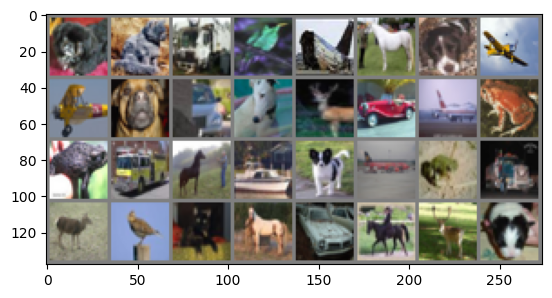

dog   cat   truck bird  airplane horse dog   airplane airplane dog   automobile dog   deer  automobile airplane frog  frog  truck horse ship  dog   airplane frog  truck deer  bird  cat   horse automobile horse deer  dog  


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define a Convolutional Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [6]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [7]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

5852234

## Train the network

In [9]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
  #for idx,(label,inputs) in enumrate(trainloader)
  #or
  #for i, data in enumerate(trainloader, 0):
      #inputs, labels = data # get the inputs; data is a list of [inputs, labels]
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [10]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [11]:
epochs = 20
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:24<00:00, 64.40it/s]


Train Loss: 1.248 | Accuracy: 55.198


100%|██████████| 313/313 [00:03<00:00, 90.87it/s]


Test Loss: 0.907 | Accuracy: 68.310

Epoch : 2


100%|██████████| 1563/1563 [00:23<00:00, 66.82it/s]


Train Loss: 0.718 | Accuracy: 74.974


100%|██████████| 313/313 [00:03<00:00, 90.71it/s]


Test Loss: 0.665 | Accuracy: 76.650

Epoch : 3


100%|██████████| 1563/1563 [00:25<00:00, 60.14it/s]


Train Loss: 0.514 | Accuracy: 82.060


100%|██████████| 313/313 [00:03<00:00, 88.42it/s]


Test Loss: 0.583 | Accuracy: 79.990

Epoch : 4


100%|██████████| 1563/1563 [00:33<00:00, 46.40it/s]


Train Loss: 0.368 | Accuracy: 87.290


100%|██████████| 313/313 [00:04<00:00, 64.97it/s]


Test Loss: 0.577 | Accuracy: 80.390

Epoch : 5


100%|██████████| 1563/1563 [00:25<00:00, 60.91it/s]


Train Loss: 0.254 | Accuracy: 91.276


100%|██████████| 313/313 [00:06<00:00, 50.19it/s]


Test Loss: 0.585 | Accuracy: 81.380

Epoch : 6


100%|██████████| 1563/1563 [00:25<00:00, 62.47it/s]


Train Loss: 0.155 | Accuracy: 94.938


100%|██████████| 313/313 [00:03<00:00, 80.29it/s]


Test Loss: 0.650 | Accuracy: 80.840

Epoch : 7


100%|██████████| 1563/1563 [00:28<00:00, 55.47it/s]


Train Loss: 0.101 | Accuracy: 96.626


100%|██████████| 313/313 [00:03<00:00, 88.65it/s]


Test Loss: 0.668 | Accuracy: 81.980

Epoch : 8


100%|██████████| 1563/1563 [00:23<00:00, 65.98it/s]


Train Loss: 0.065 | Accuracy: 97.890


100%|██████████| 313/313 [00:03<00:00, 91.08it/s]


Test Loss: 0.745 | Accuracy: 81.080

Epoch : 9


100%|██████████| 1563/1563 [00:26<00:00, 58.86it/s]


Train Loss: 0.045 | Accuracy: 98.544


100%|██████████| 313/313 [00:05<00:00, 56.63it/s]


Test Loss: 0.773 | Accuracy: 81.350

Epoch : 10


100%|██████████| 1563/1563 [00:24<00:00, 64.19it/s]


Train Loss: 0.035 | Accuracy: 98.854


100%|██████████| 313/313 [00:03<00:00, 87.36it/s]


Test Loss: 0.781 | Accuracy: 82.090

Epoch : 11


100%|██████████| 1563/1563 [00:23<00:00, 66.16it/s]


Train Loss: 0.029 | Accuracy: 99.048


100%|██████████| 313/313 [00:03<00:00, 89.68it/s]


Test Loss: 0.808 | Accuracy: 81.800

Epoch : 12


100%|██████████| 1563/1563 [00:24<00:00, 62.57it/s]


Train Loss: 0.020 | Accuracy: 99.382


100%|██████████| 313/313 [00:04<00:00, 65.37it/s]


Test Loss: 0.825 | Accuracy: 82.380

Epoch : 13


100%|██████████| 1563/1563 [00:26<00:00, 59.02it/s]


Train Loss: 0.014 | Accuracy: 99.604


100%|██████████| 313/313 [00:04<00:00, 67.52it/s]


Test Loss: 0.828 | Accuracy: 82.910

Epoch : 14


100%|██████████| 1563/1563 [00:24<00:00, 63.98it/s]


Train Loss: 0.006 | Accuracy: 99.864


100%|██████████| 313/313 [00:05<00:00, 61.86it/s]


Test Loss: 0.834 | Accuracy: 83.540

Epoch : 15


100%|██████████| 1563/1563 [00:27<00:00, 57.03it/s]


Train Loss: 0.003 | Accuracy: 99.962


100%|██████████| 313/313 [00:05<00:00, 58.33it/s]


Test Loss: 0.811 | Accuracy: 83.530

Epoch : 16


100%|██████████| 1563/1563 [00:23<00:00, 65.74it/s]


Train Loss: 0.001 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 73.60it/s]


Test Loss: 0.819 | Accuracy: 83.860

Epoch : 17


100%|██████████| 1563/1563 [00:28<00:00, 55.72it/s]


Train Loss: 0.000 | Accuracy: 99.998


100%|██████████| 313/313 [00:04<00:00, 64.22it/s]


Test Loss: 0.825 | Accuracy: 83.950

Epoch : 18


100%|██████████| 1563/1563 [00:29<00:00, 53.60it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 69.28it/s]


Test Loss: 0.837 | Accuracy: 83.760

Epoch : 19


100%|██████████| 1563/1563 [00:29<00:00, 52.89it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.90it/s]


Test Loss: 0.838 | Accuracy: 83.990

Epoch : 20


100%|██████████| 1563/1563 [00:26<00:00, 60.09it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 88.29it/s]

Test Loss: 0.840 | Accuracy: 84.080


## Drowing plots

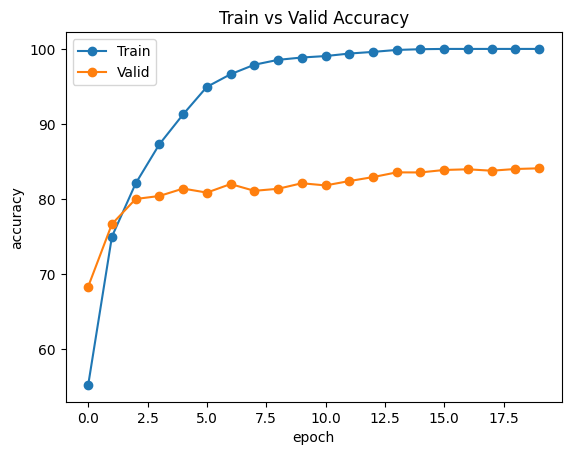

In [14]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

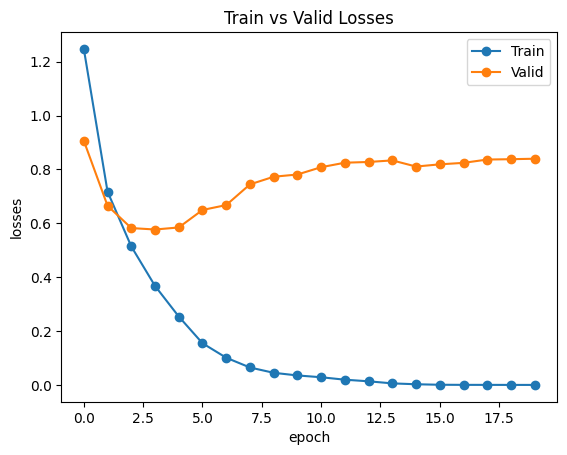

In [15]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [16]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:04<00:00, 66.92it/s]


In [17]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 4, 2, 3, 0, 9, 6, 6, 5, 4, 5, 9, 8, 4, 1, 9, 5, 4, 6, 3, 6, 0, 9, 3, 3, 7, 6, 9, 8, 0, 3, 8, 8, 7, 5, 5, 6, 7, 3, 6, 1, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 8, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 9, 4, 7, 8, 9, 0, 6, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 2, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 5, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 3, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 8, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 5, 8, 5, 7, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 9, 4, 3, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 6, 1, 8, 2, 2, 5, 5, 9, 9, 4, 0, 3, 0, 8, 9, 8, 1, 5, 3, 8, 8, 2, 4, 7, 0, 2, 5, 6, 3, 8, 5, 0, 2, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 1, 3, 4, 6, 0, 0, 6, 6, 6, 5, 2, 6, 1, 9, 2, 9, 4, 8, 6, 0, 0, 4, 0, 7, 7, 5, 5, 3, 3, 2, 2, 7, 1, 7, 5, 4, 6, 1, 9, 3, 

In [18]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [19]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [21]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,875,9,20,15,5,3,5,7,43,18
automobile,7,918,2,5,3,1,3,0,15,46
bird,45,2,758,32,56,33,43,18,8,5
cat,16,5,54,685,39,120,42,19,15,5
deer,9,3,44,44,831,17,24,23,4,1
dog,8,1,23,133,23,765,14,27,0,6
frog,4,1,31,40,14,9,889,5,4,3
horse,10,1,15,33,36,29,2,867,1,6
ship,35,8,5,8,2,3,3,4,918,14
truck,21,38,3,9,2,1,2,4,18,902


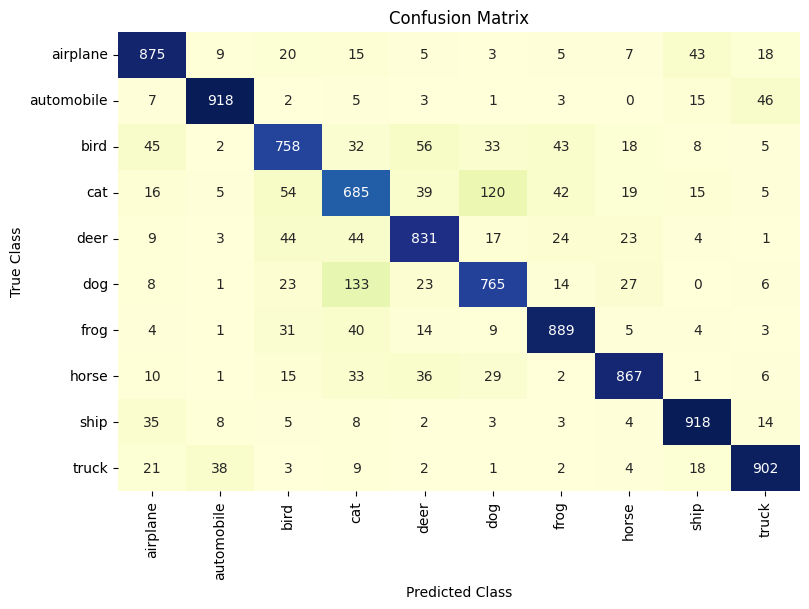

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()